<a href="https://colab.research.google.com/github/seekerpig/cartpole_reinforcementlearning/blob/main/final_cartpole_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial and Sample Code for Balancing a Pole on a Cart

## Installing dependencies:

In [1]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install gym[classic_control]
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 62.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.2 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successfully uninstalled setuptools-57.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.9.0 requires jedi>=0.10, which is not installed.
cvxpy 1.2.3 requires setuptools<=64.0.2, but you have setuptools 67.4.0 which is incompatible.


## Importing dependencies and define helper functions

In [2]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

In [3]:
# does not work in colab
# import gym
# import pygame
# from gym.utils.play import play
# import os
# os.environ["SDL_VIDEODRIVER"] = "directfb"
# mapping = {(pygame.K_LEFT,): 0, (pygame.K_RIGHT,): 1}
# play(gym.make("CartPole-v0"), keys_to_action=mapping)

## Task 1: Development of an RL agent

In [4]:
#install and import library for discretizer
!pip install -U scikit-learn



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Actual RL Agent implementation:




# For training the agent, we will be using Q-Learning.

How Q-learning works for this cartpole experiment is...

In [5]:
#Importing various libraries
#KBinsDiscretizer is used for creating bins for a range of values and for converting any continuous value into one of the bin created.
from sklearn.preprocessing import KBinsDiscretizer
from typing import Tuple
import math


#Setup environment for CartPole-v1
env = gym.make("CartPole-v1")
observation = env.reset()

#### First, due to the nature of the continuous values given by the observation state space, we will need to convert those values into the nearest bin as discrete value in order to use Q-learning else there will be too many combinations of observation state and action to train the agent.

#### Initially we tried to create a bin size of 20 for each of the 4 attributes in an observation, but however we soon realised after training the agent multiple times, we were not able to get a good model with consistently high reward. This is because if we have 20 bin size for each attribute, and we have a total of 4 attribute, then there would be 20^4 possible combinations, which would require a ridiculously large amount of episodes to ensure we train each combination and its action pair.

#### Therefore, based on the attributes in each observations, and after training the agent multiple times using the 4 different attributes, instead of using all 4 attributes from each observation in our training model, we will only look at Cart Position, Pole Angle and Pole Angular Velocity, since these are the most important for keeping the pole upright (pole angle and pole velocity) and also ensure cart stays in the screen (cart position) while keeping pole upright.

#### Also, after multiple trials of different bin sizes, we've determined that pole angle and pole velocity deserves more bins because any slight variation of angle/velocity matters in whether pole stays upright.

#### This is important because, with more attributes and more bins, this means in our Q-Table, we will have many combinations of the attributes, which would require exponentially more episodes and training in order to ensure that each state, action in Q-table is trained properly.


In [6]:
import math
print(-math.radians(50))

env = gym.make("CartPole-v1")
print(env.observation_space.low[2])
print(env.observation_space.high[2])

-0.8726646259971648
-0.41887903
0.41887903


In [7]:

#5 bin size for cart position, 10 bin each for pole angle and pole angular velocity.
bins_sizes = (5,10,10)

#also note that when working with lower and upper bounds for the bins, for velocity of pole, is -inf and inf, 
#but however based on actual observations, -1 and 1 is a sufficient upper and lower bound for pole velocity 
#since splitting the range of -inf and inf into bins is difficult and each bin would also be too huge.
lower_bounds = [env.observation_space.low[0], env.observation_space.low[2], -1]
upper_bounds = [env.observation_space.high[0], env.observation_space.high[2], 1]

#function used to convert continuous values into discrete values 
def discretizer(cartpos, cartvelocity, angle, pole_velocity) -> Tuple[int,...]:
  #given the state, we have 4 observed values
  #using KBinsDiscretizer, we fit our lower and upper bounds into the bin sizes.
    kbindiscretizer = KBinsDiscretizer(n_bins = bins_sizes, encode='ordinal', strategy ='uniform')
    kbindiscretizer.fit([lower_bounds, upper_bounds])

  #Given an observation state, we convert each continuous value into a discrete one and return it.
    return tuple(map(int,kbindiscretizer.transform([[cartpos, angle, pole_velocity]])[0]))



In [8]:
#Next we can create a qtable with zeros
Q_table = np.zeros(bins_sizes + (env.action_space.n,))

#Each state in Q_table consist of cart position (5 possible bins), pole angle (10 possible bins) and pole angular velocity (10 possible bins)
#Each state has 2 actions, hence we get Q_table.shape is (5,10,10,2)
Q_table.shape


(5, 10, 10, 2)

In [9]:

#Configure number of episodes to train agent
n_episodes = 2000

#Define configurations for learning rate and epsilon (exploration)

#learning rate gradually decreases as episodes increases
def learning_rate(episodeNumber, min_learning_rate =0.01 ):
    return max(min_learning_rate, min(1.0, 1.0 - math.log10((episodeNumber + 1) / 25)))

#exploration rate decreases as episodes increases
def exploration_rate(n : int, min_rate= 0.1 ) -> float :
    return max(min_rate, min(1, 1.0 - math.log10((n  + 1) / 25)))


In [10]:
#Return the best action based on Q_table
def trained_policy( state : tuple ):
    return np.argmax(Q_table[state])

In [11]:



#Train agent
env = gym.make('CartPole-v1')
#env = gym.make('CartPole-v1', render_mode='human')

for e in range(n_episodes):
    print(e)
    obs = env.reset()
    #print(*env.reset()[0])
    #print(*obs[0])
    
    done = False

    current_state = discretizer(*obs)
    
    while done==False:
        
        # policy action 
        action = trained_policy(current_state) # exploit
        
        #check whether a random number(0,1) is < epsilon
        #if yes, choose a random action to explore
        if np.random.random() < exploration_rate(e) : 
            action = env.action_space.sample() 
         

        obs, reward, done, info = env.step(action)
        #print("obs is", obs)
        
        #if reach end state, get out of while loop
        if (done):
          break
        else:

          #discretize the new_state observation into discrete values
            new_state = discretizer(*obs)
        
            
            lr = learning_rate(e)
            future_optimal_value = np.max(Q_table[new_state])
            discount = 1

            #update Qtable based on q-learning 
            new_value_for_stateactionpair = reward + discount * future_optimal_value
            old_value = Q_table[current_state][action]
            Q_table[current_state][action] = (1-lr)*old_value + lr*new_value_for_stateactionpair

            #continue to the next state 
            current_state = new_state
            
               
env.close()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

For Task 1, we can show the observation and chosen action below:

In [12]:
observation = env.reset()
obs = discretizer(*observation)
action = trained_policy(obs)
#action = rand_policy_agent(observation)
print("Observation:", observation)
print("Chosen action:", action)

Observation: [ 0.00068564 -0.00072209 -0.04244985  0.04234391]
Chosen action: 0


## Task 2: Demonstrate the effectiveness of the RL agent

For this task, use the agent developed in Task 1 to play the game for 100 episodes (refer to tutorial for how to play a round), record the cumulative reward for each round, and plot the reward for each round. 

#### In this task, we simply run a for loop of 100 episodes, and at the start of each episode, we reset the environment. Afterwards while the cartpole has not reached end state, we will use our trained agent policy to determine the best action. Then using that best action, we will call the environment to execute the action and retrieve the next state and reward obtained for performing the state-action pair. 

#### At the end of every episode, we append the total reward for each episode into the episode_results array.

In [13]:
env = gym.make('CartPole-v1')

episode_results = np.array([])

for _ in range(100):
    obs = env.reset()
    rewards = 0
    
    current_state, done = discretizer(*obs), False
    while done == False:
        #print(obs[0][0])

        actions = trained_policy(current_state)
        #print(actions)
        obs, reward, done, info = env.step(actions)
        rewards += reward
        
        new_state = discretizer(*obs)
        current_state = new_state
        #print(obs[0])
        #env.render()
        #time.sleep(0.05)

    #print(rewards)        
    episode_results = np.append(episode_results, rewards)

print("training complete, episode results populated")
env.close()

training complete, episode results populated


#### After getting 100 episodes worth of results, we can plot the results to see how well and consistent each episode performed in of result obtained. 0 is no reward and 500 is the max reward achievable.

Print the average reward over the 100 episodes.

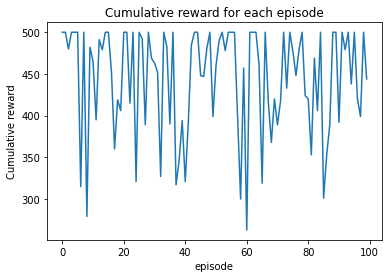

In [14]:



plt.plot(episode_results)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()

#### This is the requirement stated in Lab that we have to pass. It checks whether the mean of all the episode's rewards is greater than 195.

In [15]:
print("Average cumulative reward:", episode_results.mean())
print("Is my agent good enough?", episode_results.mean() > 195)

Average cumulative reward: 444.18
Is my agent good enough? True


## Task 3: Render one episode played by the agent

In this portion, since the agent is already trained, we can simply generate 1 episode and render the episode to see how the cartpole behaves based on our training model using Q-learning. The longer it stays upright, the higher rewards obtain.

Plug your agent to the code below to obtain rendered result.

In [16]:
env = RecordVideo(gym.make("CartPole-v1"), "./video")
observation = env.reset()
while True:
    env.render()
    #your agent goes here
    #action = rand_policy_agent(observation)
    action = trained_policy(discretizer(*observation))
    observation, reward, done, info = env.step(action) 
    if done: 
      break;    
env.close()
show_video()